# Part Combination Space Exploration

This is a notebook developed to leverage the new SysML v2 semantics for nested features and instantiation of models to generate instances of M1 system models as feedstock for analysis pipelines.

In [1]:
import requests
import getpass
import math

from __future__ import print_function

import time
import sysml_v2_api_client
from sysml_v2_api_client.rest import ApiException
from pprint import pprint

import json
import networkx as NX

import random
import copy

# Configure API Server Connection

In [2]:
sysml_api_base_url = 'http://sysml2-sst.intercax.com:9000'

## Activate APIs

Connect the API classes to the server

In [3]:
configuration = sysml_v2_api_client.Configuration(
    host = sysml_api_base_url
)

projects_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    project_api_instance = sysml_v2_api_client.ProjectApi(api_client)
    
commits_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    commits_api_instance = sysml_v2_api_client.CommitApi(api_client)
    
elements_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    elements_api_instance = sysml_v2_api_client.ElementApi(api_client)

## Pull down commits and elements catalogs

With the API handles, use the pre-built methods to get lists of commits and elements.

In [4]:
project_api_instance

In [5]:
kerbal_proj = [my_proj for my_proj in project_api_instance.get_projects() if my_proj.name.find('Kerbal') > -1][14]
kerbal_proj

{'id': 'd2922960-028d-4534-a8ee-476aa26d1d25',
 'name': 'Kerbal Sat Mar 06 15:49:41 UTC 2021',
 'type': 'Project'}

In [6]:
try:
    # Get commits by project
    commits_response = commits_api_instance.get_commits_by_project(kerbal_proj.id)
    pprint(commits_response)
except ApiException as e:
    print("Exception when calling CommitApi->get_commits_by_project: %s\n" % e)

[{'change': None,
 'containing_project': {'id': 'd2922960-028d-4534-a8ee-476aa26d1d25'},
 'id': '61cb843b-b6ad-4868-9fb8-29094e59827e',
 'previous_commit': None,
 'type': 'Commit'}]


In [7]:
elements = []

try:
    # Get commits by project
    elements = elements_api_instance.get_elements_by_project_commit(kerbal_proj.id, commits_response[0].id)
except ApiException as e:
    print("Exception when calling ElementApi->get_elements_by_project_commit: %s\n" % e)

In [8]:
len(elements)

100

In [9]:
pprint(elements[0])

{'id': '001b3767-ac0e-4191-a830-6a93c5bd3a08',
 'identifier': '001b3767-ac0e-4191-a830-6a93c5bd3a08',
 'type': 'Feature'}


# Gather Element Data

Since the generated API doesn't have much detail for elements, need to do this more hands-on.

Not elegant below to just have a larger page size, should implement paging later on.

In [10]:
elements_url = (sysml_api_base_url +
                '/projects/{0}/commits/{1}/elements?page[size]=2000').format(kerbal_proj.id, commits_response[0].id)

In [11]:
elements_url

'http://sysml2-sst.intercax.com:9000/projects/d2922960-028d-4534-a8ee-476aa26d1d25/commits/61cb843b-b6ad-4868-9fb8-29094e59827e/elements?page[size]=2000'

In [12]:
elements_response = requests.get(
    elements_url
)

In [13]:
elements_data = elements_response.json()

Split the elements into relationships and non-relationships. This will let us work with graph representations and a graph understanding of the underlying model.

In [14]:
len(elements_data)

499

In [15]:
non_relations = [non_relation for non_relation in elements_data if not 'relatedElement' in non_relation]

In [16]:
relations = [relation for relation in elements_data if 'relatedElement' in relation]

In [17]:
len(non_relations)

209

In [18]:
len(relations)

290

In [19]:
['{0} : {1}'.format(nr['name'], nr['@type']) for nr in non_relations]

['$result : Feature',
 'None : LiteralInteger',
 '$result : Feature',
 'None : ReferenceUsage',
 'boosters : PartUsage',
 'start : ActionUsage',
 'None : TransitionUsage',
 'Oxidizer : ItemDefinition',
 'Specific Impulse : AttributeUsage',
 '$result : Feature',
 '$result : Feature',
 '$result : Feature',
 'Full Mass : AttributeUsage',
 '$result : Feature',
 'None : SourceEnd',
 'None : ReferenceUsage',
 '$result : Feature',
 'Thrust : AttributeUsage',
 'None : LiteralReal',
 'None : SourceEnd',
 'None : LiteralInteger',
 'None : LiteralInteger',
 'None : LiteralReal',
 'None : AcceptActionUsage',
 'Empty Mass : AttributeUsage',
 'Full Mass : AttributeUsage',
 'None : ReferenceUsage',
 'stages : PartUsage',
 'Fuel : ItemDefinition',
 'Gravity Turn Ascent : ActionDefinition',
 'IgniteSignal : ItemDefinition',
 '$result : Feature',
 'Empty Mass : AttributeUsage',
 'None : LiteralReal',
 'None : OperatorExpression',
 'Thrust : AttributeUsage',
 '$result : Feature',
 'Carried Stage : Refere

# Connect to Semantic Libraries

The real work comes in the connection to M1 and then its interpretation at M0. Start processing the model here.

In [20]:
id_memo_dict = {}

In [21]:
def get_name_by_id(id_to_check):
    if id_to_check in id_memo_dict:
        return id_memo_dict[id_to_check]['name']
    else:
        for found_ele in elements_data:
            if found_ele['@id'] == id_to_check:
                return found_ele['name']
    
    return id_to_check

In [22]:
def get_metatype_by_id(id_to_check):
    ele_spot = [found_ele for found_ele in elements_data if found_ele['@id'] == id_to_check]
    return ele_spot[0]['@type']

## Part Definitions and the Usage Features

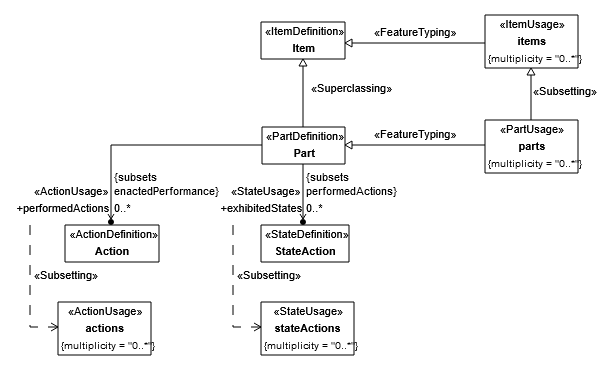

The "parts" feature will always be typed by Part, any additional features applied to a PartDefinition will subset parts.

In [23]:
part_defs = [part_def for part_def in non_relations if part_def['@type'] == 'PartDefinition']

In [24]:
["{0}".format(part_def['name']) for part_def in part_defs]

['Rocket',
 'Kerbal Rocket Part',
 'RT-5 "Flea" Solid Fuel Booster',
 'Liquid Engine',
 'FL-T200 Fuel Tank',
 'FL-T100 Fuel Tank',
 'Fuel Tank Section',
 'Solid Booster',
 'Mk1 Command Pod',
 'Solid Stage',
 'Liquid Stage',
 'Coupler',
 'Parachute',
 'LV-T45 "Swivel" Liquid Fuel Engine',
 'RT-10 "Hammer" Solid Fuel Booster',
 'Pod',
 'Rocket Stage']

In [25]:
for part_def in part_defs:
    id_memo_dict.update({part_def['@id']: part_def})

## Subclassing Graph

Trace the path from the most specialized PartDefinitions back to the library. Pack the results into a graph for later computations on going up and down the specialization tree.

In [26]:
superclasses = [sup for sup in relations if sup['@type'] == 'Superclassing']

In [27]:
len(superclasses)

15

In [28]:
superclassing_graph = NX.DiGraph()
subclassing_graph = NX.DiGraph()

In [29]:
for sup in superclasses:
    if sup['specific']['@id'] in id_memo_dict:
        subclassing_graph.add_edge(sup['general']['@id'], sup['specific']['@id'])
        superclassing_graph.add_edge(sup['specific']['@id'], sup['general']['@id'])

In [30]:
['{0} :> {1}'.format(
    get_name_by_id(sup['subclass']['@id']), get_name_by_id(sup['superclass']['@id'])
) for sup in superclasses if sup['subclass']['@id'] in id_memo_dict]

['Solid Booster :> Kerbal Rocket Part',
 'RT-5 "Flea" Solid Fuel Booster :> Solid Booster',
 'Solid Stage :> Rocket Stage',
 'LV-T45 "Swivel" Liquid Fuel Engine :> Liquid Engine',
 'Mk1 Command Pod :> Pod',
 'RT-10 "Hammer" Solid Fuel Booster :> Solid Booster',
 'Pod :> Kerbal Rocket Part',
 'Liquid Engine :> Kerbal Rocket Part',
 'Parachute :> Kerbal Rocket Part',
 'FL-T100 Fuel Tank :> Fuel Tank Section',
 'Fuel Tank Section :> Kerbal Rocket Part',
 'Liquid Stage :> Rocket Stage',
 'FL-T200 Fuel Tank :> Fuel Tank Section',
 'Coupler :> Kerbal Rocket Part']

Draw the superclassing graph.

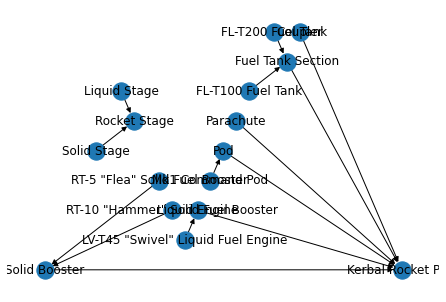

In [31]:
superclassing_graph_labels = {}
for node in superclassing_graph.nodes():
    superclassing_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(superclassing_graph, labels=superclassing_graph_labels)

## PartUsages

Inspect the features of the part definitions that should go into the features list.

In [32]:
part_uses = [part_use for part_use in non_relations if part_use['@type'] == 'PartUsage']
for part_use in part_uses:
    id_memo_dict.update({part_use['@id']: part_use})

In [33]:
len(part_uses)

5

In [34]:
[get_name_by_id(part_use['@id']) for part_use in part_uses]

['boosters', 'stages', 'Coupler to Carrying Stage', 'engines', 'tanks']

Look for FeatureMemberships and TypeFeaturings to see where the features belong.

In [35]:
feature_members = [feature_member for feature_member in relations if feature_member['@type'] == 'FeatureMembership']
type_features = [type_feature for type_feature in relations if type_feature['@type'] == 'TypeFeaturings']

In [36]:
len(feature_members)

76

In [37]:
len(type_features)

0

In [38]:
part_featuring_graph = NX.DiGraph()

In [39]:
for fm in feature_members:
    if fm['memberElement']['@id'] in id_memo_dict:
        if id_memo_dict[fm['memberElement']['@id']]['@type'] == 'PartUsage':
            part_featuring_graph.add_edge(fm['memberElement']['@id'], fm['owningType']['@id'])

In [40]:
[part_featuring_graph.in_degree(node) for node in part_featuring_graph.nodes]

[0, 1, 0, 2, 0, 1, 0, 1]

In [41]:
['{0} is a member of {1}'.format(
    get_name_by_id(fm['memberElement']['@id']), get_name_by_id(fm['owningType']['@id'])
) for fm in feature_members if fm['memberElement']['@id'] in id_memo_dict]

['boosters is a member of Solid Stage',
 'engines is a member of Liquid Stage',
 'Coupler to Carrying Stage is a member of stages',
 'tanks is a member of Liquid Stage',
 'stages is a member of Rocket']

Draw the parts featuring graph.

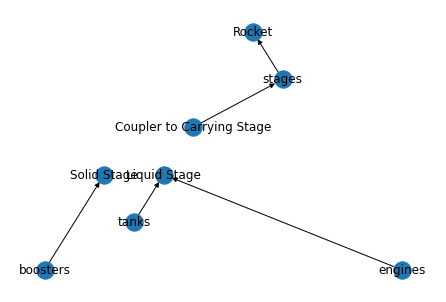

In [42]:
part_featuring_graph_labels = {}
for node in part_featuring_graph.nodes():
    part_featuring_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(part_featuring_graph, labels=part_featuring_graph_labels)

Collect multiplicities.

In [43]:
mults = [mult for mult in non_relations if mult['@type'] == 'MultiplicityRange']
integers = [integer for integer in non_relations if integer['@type'] == 'LiteralInteger']

for mult in mults:
    id_memo_dict.update({mult['@id']: mult})
    
for integer in integers:
    id_memo_dict.update({integer['@id']: integer})

In [44]:
mult_strings = []
for mult in mults:
    try:
        if mult['lowerBound'] is None and mult['upperBound'] is not None:
            mult_strings.append('[{0}]'.format(
                id_memo_dict[mult['upperBound']['@id']]['value']))
        else:
            mult_strings.append('[{0}..{1}]'.format(
                id_memo_dict[mult['lowerBound']['@id']]['value'],
                id_memo_dict[mult['upperBound']['@id']]['value']))
    except TypeError:
        print('Lower Bound is ' + str(mult['lowerBound']))
        print('Upper Bound is ' + str(mult['upperBound']))

In [45]:
mult_strings

['[1]', '[0..8]', '[0..8]', '[0..8]', '[0..30]', '[1..5]']

In [46]:
def feature_lower_multiplicity(feature):
    if feature['multiplicity'] is not None:
        if '@id' in feature['multiplicity']:
            mult = id_memo_dict[feature['multiplicity']['@id']]
            if '@id' in mult['lowerBound']:
                return id_memo_dict[mult['lowerBound']['@id']]['value']
        
    return 1

In [47]:
def feature_upper_multiplicity(feature):
    if feature['multiplicity'] is not None:
        if '@id' in feature['multiplicity']:
            mult = id_memo_dict[feature['multiplicity']['@id']]
            if '@id' in mult['upperBound']:
                return id_memo_dict[mult['upperBound']['@id']]['value']
        
    return 1

In [48]:
['{0} has multiplicity {1}..{2}'.format(
    part_use['name'], feature_lower_multiplicity(part_use), feature_upper_multiplicity(part_use)
) for part_use in part_uses]

['boosters has multiplicity 0..8',
 'stages has multiplicity 1..5',
 'Coupler to Carrying Stage has multiplicity 0..8',
 'engines has multiplicity 0..8',
 'tanks has multiplicity 0..30']

Get feature types.

In [49]:
feature_types = [feature_type for feature_type in relations if feature_type['@type'] == 'FeatureTyping']

In [50]:
def get_feature_type_name(feature):
    if len(feature['type']) > 0:
        return get_name_by_id(feature['type'][0]['@id'])
    else:
        return 'Part'

In [51]:
['{0} : {1}'.format(
    get_name_by_id(ft['typedFeature']['@id']), get_name_by_id(ft['type']['@id'])
) for ft in feature_types if ft['typedFeature']['@id'] in id_memo_dict]

['tanks : Fuel Tank Section',
 'stages : Rocket Stage',
 'boosters : Solid Booster',
 'engines : Liquid Engine',
 'Coupler to Carrying Stage : Coupler']

# Generate Instances

With the base semantic model in hand, begin to apply the rules to generate our system alternatives.

## Find number of instances for feature last positions

In SysML, the default type is PartDefinition, which is a Classifier, meaning the minimal interpretation of length one (the specific instance). Nesting parts then have an interpretation as expected by systems engineers, namely that the instances "stack" in order to provide a navigation from top-level assembly to leaf component.

In [52]:
['{0} needs {1} instances of type {2}'.format(
    part_use['name'], feature_upper_multiplicity(part_use), get_feature_type_name(part_use)
) for part_use in part_uses]

['boosters needs 8 instances of type Solid Booster',
 'stages needs 5 instances of type Rocket Stage',
 'Coupler to Carrying Stage needs 8 instances of type Coupler',
 'engines needs 8 instances of type Liquid Engine',
 'tanks needs 30 instances of type Fuel Tank Section']

Automatically shorten names so that sequences remain readable when printed.

In [53]:
shorten_pre_bake = {
    'RT-10 "Hammer" Solid Fuel Booster': "RT-10",
    'RT-5 "Flea" Solid Fuel Booster': "RT-5",
    'LV-T45 "Swivel" Liquid Fuel Engine': "LV-T45",
    'FL-T100 Fuel Tank': "FL-T100",
    'FL-T200 Fuel Tank': "FL-T200"
}

In [54]:
def shorten_name(name):
    short_name = ''
    if len(name) > 5:
        if shorten_pre_bake is not None:
            if name in shorten_pre_bake:
                return shorten_pre_bake[name]
        space_place = name.find(' ')
        if space_place > -1:
            short_name = short_name + name[0]
            short_name = short_name + name[space_place + 1]
            next_space = name.find(' ', space_place + 1)
            while next_space > -1:
                short_name = short_name + name[next_space + 1]
                next_space = name.find(' ', next_space + 1)
            return short_name
    return name

In [55]:
class Instance():
    def __init__(self, name, index):
        self.name = shorten_name(name) + '#' + str(index)
        
    def __repr__(self):
        return self.name

In [56]:
multiplicity_dict = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in multiplicity_dict:
        old_val = multiplicity_dict[part_use]
        multiplicity_dict.update({type_name: old_val + feature_upper_multiplicity(part_use)})
    else:
        multiplicity_dict.update({type_name: feature_upper_multiplicity(part_use)})

In [57]:
multiplicity_dict

{'Solid Booster': 8,
 'Rocket Stage': 5,
 'Coupler': 8,
 'Liquid Engine': 8,
 'Fuel Tank Section': 30}

## Determine the size of the universe of instances needed for creating alternatives

Use feature membership together with multiplicity to decide how many individuals are needed.

### Building the banded graph

Build up a graph with the SysML v1 banded style of part-type-part-type (with superclassing).

In [58]:
banded_feature_graph = NX.DiGraph()

In [59]:
for fm in feature_members:
    if fm['memberElement']['@id'] in id_memo_dict:
        if id_memo_dict[fm['memberElement']['@id']]['@type'] == 'PartUsage':
            banded_feature_graph.add_edge(fm['memberElement']['@id'], fm['owningType']['@id'])

for ft in feature_types:
    if ft['typedFeature']['@id'] in id_memo_dict:
        if id_memo_dict[ft['typedFeature']['@id']]['@type'] == 'PartUsage':
            banded_feature_graph.add_edge(ft['type']['@id'], ft['typedFeature']['@id'])
            
for sup in superclasses:
    if sup['specific']['@id'] in id_memo_dict:
        banded_feature_graph.add_edge(sup['specific']['@id'], sup['general']['@id'])

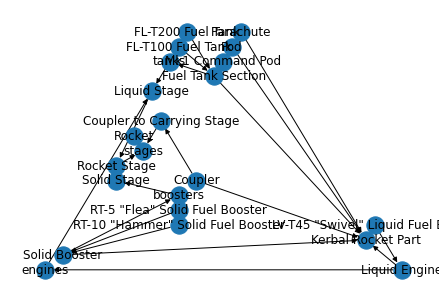

In [60]:
banded_feature_graph_labels = {}
for node in banded_feature_graph.nodes():
    banded_feature_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(banded_feature_graph, labels=banded_feature_graph_labels)

In [61]:
part_leaves = [id_memo_dict[node]
    for node in part_featuring_graph.nodes
        if part_featuring_graph.in_degree(node) == 0]

In [62]:
part_roots = [id_memo_dict[node]
    for node in part_featuring_graph.nodes
        if part_featuring_graph.out_degree(node) == 0]

In [63]:
banded_roots = [id_memo_dict[node]
    for node in banded_feature_graph.nodes
        if banded_feature_graph.out_degree(node) == 0]

In [64]:
[part_leaf['name'] for part_leaf in part_leaves]

['boosters', 'engines', 'Coupler to Carrying Stage', 'tanks']

In [65]:
[part_root['name'] for part_root in part_roots]

['Solid Stage', 'Liquid Stage', 'Rocket']

In [66]:
[banded_root['name'] for banded_root in banded_roots]

['Rocket', 'Kerbal Rocket Part']

Correct the multiplicities by considering nesting.part_uses

In [67]:
part_multiplicity = {}

for part_use in part_uses:
    corrected_mult = 0
    for part_tree_root in banded_roots:
        try:
            part_path = NX.shortest_path(banded_feature_graph, part_use['@id'], part_tree_root['@id'])
            # TODO: check that the path actually exists
            corrected_mult = math.prod([feature_upper_multiplicity(id_memo_dict[node]) for node in part_path])
        except NX.NetworkXNoPath:
            pass
    part_multiplicity.update({part_use['@id']: corrected_mult})

In [68]:
part_multiplicity

{'06a1824e-0f31-4aa7-8a61-4f2ae6c10c44': 40,
 '2159c437-6932-4d65-982f-483e7f4c9bc4': 5,
 '4f7a2ae1-063c-4c20-b8f3-749100a5dff7': 40,
 '94b08c23-2e8d-480a-a777-1b652ca83d8b': 40,
 'a8a926c9-88a9-4937-a08f-ef6fab605b01': 150}

### Subdivide Abstract Feature Types

Look at the feature types for where they are abstract and then generate instances from the more specific types.

In [69]:
[get_name_by_id(node) for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

['RT-5 "Flea" Solid Fuel Booster',
 'Solid Stage',
 'LV-T45 "Swivel" Liquid Fuel Engine',
 'Mk1 Command Pod',
 'RT-10 "Hammer" Solid Fuel Booster',
 'Parachute',
 'FL-T100 Fuel Tank',
 'Liquid Stage',
 'FL-T200 Fuel Tank',
 'Coupler']

In [70]:
corrected_multiplicity_dict = {}
type_id_pairs = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in corrected_multiplicity_dict:
        old_val = corrected_multiplicity_dict[part_use]
        corrected_multiplicity_dict.update({type_name: old_val + part_multiplicity[part_use['@id']]})
    else:
        corrected_multiplicity_dict.update({type_name: part_multiplicity[part_use['@id']]})
        if len(part_use['type']) > 0:
            type_id_pairs.update({type_name: part_use['type'][0]['@id']})

In [71]:
type_id_pairs

{'Solid Booster': '729882d4-2234-44f1-8bc3-1f20188a234c',
 'Rocket Stage': 'ef7a2c36-7e2d-447a-8b32-0d4398379e46',
 'Coupler': '8d7a54a4-dbc8-4204-accb-bafadb48896e',
 'Liquid Engine': '5549c46e-e196-45e6-9c28-214688b3906b',
 'Fuel Tank Section': '6a6d5851-5f44-4f12-bfff-271c8a7d50de'}

In [72]:
corrected_multiplicity_dict

{'Solid Booster': 40,
 'Rocket Stage': 5,
 'Coupler': 40,
 'Liquid Engine': 40,
 'Fuel Tank Section': 150}

## Generate Random Alternatives

Start creating the alternatives with random draws on multiplicity. This will be our space for investigation for weights, thrust-to-weight ratios at stage ignitions, delta-Vs, and initial and burnout masses.

In [73]:
no_alts_to_create = 50

In [74]:
partitioned_multiplicity_dicts = []

for step in range(0, no_alts_to_create):

    partitioned_multiplicity_dict = {}

    for key in corrected_multiplicity_dict:
        if key in type_id_pairs:
            key_id = type_id_pairs[key]
            type_obj = id_memo_dict[key_id]
            if type_obj['isAbstract']:
                local_partition = {}
                if key_id in subclassing_graph.nodes:
                    no_splits = len(list(subclassing_graph.successors(key_id)))
                    taken = 0
                    for indx, succ in enumerate(subclassing_graph.successors(key_id)):
                        if indx < no_splits - 1:
                            draw = random.randint(0, corrected_multiplicity_dict[key])
                            taken = taken + draw
                        else:
                            draw = corrected_multiplicity_dict[key] - taken
                        local_partition.update({get_name_by_id(succ): draw})
                partitioned_multiplicity_dict.update({key: local_partition})
            else:
                partitioned_multiplicity_dict.update({key: corrected_multiplicity_dict[key]})
                
    partitioned_multiplicity_dicts.append(partitioned_multiplicity_dict)

In [75]:
partitioned_multiplicity_dicts[0]

{'Solid Booster': {'RT-5 "Flea" Solid Fuel Booster': 35,
  'RT-10 "Hammer" Solid Fuel Booster': 5},
 'Rocket Stage': {'Solid Stage': 3, 'Liquid Stage': 2},
 'Coupler': 40,
 'Liquid Engine': {'LV-T45 "Swivel" Liquid Fuel Engine': 40},
 'Fuel Tank Section': {'FL-T100 Fuel Tank': 46, 'FL-T200 Fuel Tank': 104}}

- [ ] TODO: Fix the dictionary to have keys as IDs, not name

In [76]:
classifier_instance_dicts = []
classifier_memo_dicts = []

for step in range(0, no_alts_to_create):

    classifier_instance_dict = {}
    classifier_memo_dict = {}
    
    partitioned_multiplicity_dict = partitioned_multiplicity_dicts[step]

    for mult_key in partitioned_multiplicity_dict:
        instances_list = []
        if isinstance(partitioned_multiplicity_dict[mult_key], dict):
            for special_key in partitioned_multiplicity_dict[mult_key]:
                sub_instances_list = []
                instances_number = (partitioned_multiplicity_dict[mult_key][special_key] + 1)
                for index in range(1, instances_number):
                    new_instance = Instance(special_key, index)
                    instances_list.append(new_instance)
                    sub_instances_list.append(new_instance)
                    classifier_memo_dict.update({new_instance.name: [special_key, mult_key]})
                classifier_instance_dict.update({special_key: sub_instances_list})
            classifier_instance_dict.update({mult_key: instances_list})
        else:
            instances_number = (corrected_multiplicity_dict[mult_key] + 1)
            for index in range(1, instances_number):
                new_instance = Instance(mult_key, index)
                instances_list.append(new_instance)
                classifier_memo_dict.update({new_instance.name: [mult_key]})
            classifier_instance_dict.update({mult_key: instances_list})
            
    classifier_instance_dicts.append(classifier_instance_dict)
    classifier_memo_dicts.append(classifier_memo_dict)

Now that the universe of instances has been calculated, we can look at how they can be sequenced. This method is probably fragile so will need revisions.
In this case, found that it can't handle unconnected featuring graph components.

In [77]:
[get_name_by_id(node) for node in NX.topological_sort(part_featuring_graph.reverse())]

['Rocket',
 'stages',
 'Coupler to Carrying Stage',
 'Liquid Stage',
 'tanks',
 'engines',
 'Solid Stage',
 'boosters']

In [78]:
sorted_feature_groups = []

In [79]:
for comp in NX.connected_components(part_featuring_graph.to_undirected()):
    connected_sub = NX.subgraph(part_featuring_graph, list(comp))
    sorted_feature_groups.append(
        [node for node in NX.topological_sort(connected_sub.reverse())]
    )
    print([get_name_by_id(node) for node in NX.topological_sort(connected_sub.reverse())])

['Solid Stage', 'boosters']
['Liquid Stage', 'tanks', 'engines']
['Rocket', 'stages', 'Coupler to Carrying Stage']


In [80]:
sorted_feature_groups

[['801c0f02-bc4a-431c-8efe-fad12cdc3ade',
  '06a1824e-0f31-4aa7-8a61-4f2ae6c10c44'],
 ['818ff052-7c79-41f0-8bd5-aafb521f9f3f',
  'a8a926c9-88a9-4937-a08f-ef6fab605b01',
  '94b08c23-2e8d-480a-a777-1b652ca83d8b'],
 ['2f659ef6-2b50-4919-832b-a7889cb2e8ed',
  '2159c437-6932-4d65-982f-483e7f4c9bc4',
  '4f7a2ae1-063c-4c20-b8f3-749100a5dff7']]

In [81]:
for classifier_instance_dict in classifier_instance_dicts:

    for part_tree_root in part_roots:
        root_name = get_name_by_id(part_tree_root['@id'])
        if root_name not in classifier_instance_dict:
            classifier_instance_dict.update({root_name: Instance(root_name, 1)})

The topological sort on the graph of feature membership determines the order in which to build up sets of instances for features.

In [82]:
feature_sequence_dictionaries = []

for step in range(0, no_alts_to_create):
    
    classifier_instance_dict = classifier_instance_dicts[step]
    
    feature_sequence_dictionary = {}
    covered_draw_dict = {}
    
    for sorting in sorted_feature_groups:
        for indx, node in enumerate(sorting):
            if indx > 0:
                new_dict = {}
                # get current parent from the graph
                for pred in part_featuring_graph.successors(node):
                    current_parent = pred
                    #print(get_name_by_id(current_parent))

                sequence_of_sequences = []

                for sequence in feature_sequence_dictionary[current_parent]:

                    test_mult = random.randint(
                        feature_lower_multiplicity(id_memo_dict[node]),
                        feature_upper_multiplicity(id_memo_dict[node])
                    )

                    for ind_j in range(0, test_mult):
                        new_sequence = copy.deepcopy(sequence)
                        # find the type of the current feature node
                        node_type = get_feature_type_name(id_memo_dict[node])

                        need_draw = True
                        
                        safety_count = 0

                        while(need_draw and safety_count < 100):

                            draw = random.randint(
                                0,
                                corrected_multiplicity_dict[node_type] - 1
                            )
                            #print(classifier_instance_dict[node_type][draw])

                            if node_type in covered_draw_dict:
                                if classifier_instance_dict[node_type][draw] in covered_draw_dict[node_type]:
                                    pass
                                    #need_draw = False
                                else:
                                    covered_draw_dict[node_type].append(classifier_instance_dict[node_type][draw])
                                    need_draw = False
                            else:
                                covered_draw_dict.update({node_type : [classifier_instance_dict[node_type][draw]]})
                                need_draw = False

                            safety_count = safety_count + 1
                            if safety_count == 99:
                                print('Safety count hit when trying to place ' + 
                                      str(classifier_instance_dict[node_type][draw]) + ' under ' +
                                     str(new_sequence))
                                print('Covered dict is ' + str(covered_draw_dict[node_type]))
                        
                        new_sequence.append(classifier_instance_dict[node_type][draw])

                        sequence_of_sequences.append(new_sequence)

                feature_sequence_dictionary.update({node: sequence_of_sequences})

            elif indx == 0:
                if isinstance(classifier_instance_dict[get_name_by_id(node)], list):
                    starter_list = []
                    for item in classifier_instance_dict[get_name_by_id(node)]:
                        starter_list.append([item])
                    # handle case where main type has more than one instance
                    feature_sequence_dictionary.update({node: starter_list})
                    #print(starter_list)
                    if len(starter_list) == 0:
                        break
                else:
                    feature_sequence_dictionary.update({node: [[classifier_instance_dict[get_name_by_id(node)]]]})
            
    feature_sequence_dictionaries.append(feature_sequence_dictionary)

In [83]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in feature_sequence_dictionary:
            print(get_name_by_id(key) + ', id ' + key)
            for seq in feature_sequence_dictionary[key]:
                print(str(seq))

Solution #0
Solid Stage, id 801c0f02-bc4a-431c-8efe-fad12cdc3ade
[SS#1]
[SS#2]
[SS#3]
boosters, id 06a1824e-0f31-4aa7-8a61-4f2ae6c10c44
[SS#1, RT-5#11]
[SS#1, RT-5#33]
[SS#2, RT-5#12]
[SS#2, RT-10#5]
[SS#2, RT-5#29]
[SS#2, RT-5#4]
[SS#2, RT-5#10]
[SS#2, RT-5#19]
[SS#3, RT-5#17]
[SS#3, RT-10#3]
Liquid Stage, id 818ff052-7c79-41f0-8bd5-aafb521f9f3f
[LS#1]
[LS#2]
tanks, id a8a926c9-88a9-4937-a08f-ef6fab605b01
[LS#1, FL-T100#29]
[LS#1, FL-T100#20]
[LS#1, FL-T100#43]
[LS#1, FL-T100#10]
[LS#1, FL-T100#8]
[LS#1, FL-T200#71]
[LS#1, FL-T100#38]
[LS#1, FL-T200#47]
[LS#1, FL-T200#90]
[LS#1, FL-T100#40]
[LS#1, FL-T200#38]
[LS#1, FL-T200#76]
[LS#1, FL-T200#10]
[LS#1, FL-T100#1]
[LS#1, FL-T200#99]
[LS#1, FL-T200#94]
[LS#1, FL-T200#8]
[LS#1, FL-T200#100]
[LS#1, FL-T100#30]
[LS#1, FL-T200#14]
[LS#1, FL-T100#9]
[LS#1, FL-T200#2]
[LS#1, FL-T200#17]
[LS#1, FL-T200#59]
[LS#2, FL-T100#12]
[LS#2, FL-T200#65]
[LS#2, FL-T200#103]
[LS#2, FL-T100#17]
[LS#2, FL-T100#31]
[LS#2, FL-T200#70]
[LS#2, FL-T200#78]
[LS#

One more step here is to backfill the more general collections of type with what has been developed above. To make it easier to visualize, repeat the superclassing graph from before. The only thing to add is the base library kinds.

In [84]:
class_roots = [node for node in superclassing_graph.nodes if superclassing_graph.out_degree(node) == 0]
class_roots

['4082f336-ca78-4343-9776-303de7db3498',
 'ef7a2c36-7e2d-447a-8b32-0d4398379e46']

We want to look at the classifier_instance_dicts in order to see if there are classifiers without entries. If we find missing keys, look to their subsets to fill in.

In [85]:
sorted_class_groups = []

for comp in NX.connected_components(superclassing_graph.to_undirected()):
    component_list = []
    connected_sub = NX.subgraph(superclassing_graph, list(comp))
    sorted_class_groups.append(
        [node for node in NX.topological_sort(connected_sub)]
    )
    print([get_name_by_id(node) for node in NX.topological_sort(connected_sub)])

['Coupler', 'FL-T200 Fuel Tank', 'FL-T100 Fuel Tank', 'Fuel Tank Section', 'Parachute', 'RT-10 "Hammer" Solid Fuel Booster', 'Mk1 Command Pod', 'Pod', 'LV-T45 "Swivel" Liquid Fuel Engine', 'Liquid Engine', 'RT-5 "Flea" Solid Fuel Booster', 'Solid Booster', 'Kerbal Rocket Part']
['Solid Stage', 'Liquid Stage', 'Rocket Stage']


In [86]:
founds = []
for sorted_group in sorted_class_groups:
    for sorted_thing in sorted_group:
        if get_name_by_id(sorted_thing) in classifier_instance_dicts[0]:
            founds.append(sorted_thing)

In [87]:
for classifier_instance_dict in classifier_instance_dicts:
    for found in founds:
        my_group = []
        for sorted_group in sorted_class_groups:
            for thing in sorted_group:
                if thing == found:
                    my_group = sorted_group
                    break
        for item in my_group:
            if not item in founds:
                try:
                    super_path = NX.shortest_path(superclassing_graph, found, item)
                    #print ('Found path from ' + get_name_by_id(found) + ' to ' + get_name_by_id(item))
                    if get_name_by_id(item) not in classifier_instance_dict:
                        classifier_instance_dict.update({get_name_by_id(item): 
                                                        copy.deepcopy(classifier_instance_dict[get_name_by_id(found)])})
                    else:
                        for individual in classifier_instance_dict[get_name_by_id(found)]:
                            if individual not in classifier_instance_dict[get_name_by_id(item)]:
                                classifier_instance_dict[get_name_by_id(item)].append(individual)
                            #classifier_instance_dict[get_name_by_id(item)].extend(classifier_instance_dict[get_name_by_id(found)])
                except NX.NetworkXNoPath:
                    pass

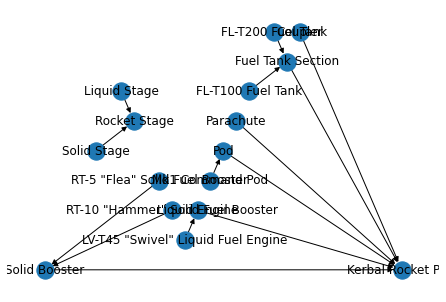

In [89]:
NX.draw_planar(superclassing_graph, labels=superclassing_graph_labels)

# Analyze and Explore Resulting Space

Now that the alternatives have been generated, we can explore the population

In [90]:
[[get_name_by_id(node), node] for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

[['RT-5 "Flea" Solid Fuel Booster', '52658dcc-be17-4be2-8960-25ec8f849691'],
 ['Solid Stage', '801c0f02-bc4a-431c-8efe-fad12cdc3ade'],
 ['LV-T45 "Swivel" Liquid Fuel Engine',
  'a3e93cd6-6d40-434f-a2ba-cb917ac86f98'],
 ['Mk1 Command Pod', '7c82d8d4-aa60-48b8-835a-73f5037e3cfd'],
 ['RT-10 "Hammer" Solid Fuel Booster', 'c06afa59-6573-4399-a95d-5ba5f50c7b5e'],
 ['Parachute', '97e92fbc-ca59-49f5-9fab-c18161814244'],
 ['FL-T100 Fuel Tank', '5ebaec8a-e022-4564-9a30-5c73ad2f6288'],
 ['Liquid Stage', '818ff052-7c79-41f0-8bd5-aafb521f9f3f'],
 ['FL-T200 Fuel Tank', '5c999b9b-2af7-4d4c-b506-477d3f9e0714'],
 ['Coupler', '8d7a54a4-dbc8-4204-accb-bafadb48896e']]

## Gather AttributeUsages and literal values

Find all the attribute usages so we can navigate to them from our parts library.

TODO: Look at using FeatureValue relationships for this

In [91]:
def get_att_literal_values(att_use):
    literal_values = []
    for att_member in att_use['ownedMember']:
        if att_member['@id'] in id_memo_dict:
            if id_memo_dict[att_member['@id']]['@type'] == 'LiteralReal':
                literal_values.append(id_memo_dict[att_member['@id']])
                
    return literal_values

In [92]:
att_uses = [att_use for att_use in non_relations if att_use['@type'] == 'AttributeUsage']
for att_use in att_uses:
    id_memo_dict.update({att_use['@id']: att_use})

Get literal reals to connect to attributes.

In [93]:
reals = [real for real in non_relations if real['@type'] == 'LiteralReal']
for real in reals:
    id_memo_dict.update({real['@id']: real})

Create objects to hold different values per instance.

In [94]:
class ValueHolder():
    
    def __init__(self, path, name, value):
        # path is list of instance references
        self.holder_string = ''
        for indx, step in enumerate(path):
            if indx == 0:
                self.holder_string = str(step)
            else:
                self.holder_string = self.holder_string + '.' + str(step)
        self.holder_string = self.holder_string + '.' + name
        self.value = value
    
    def __repr__(self):
        if self.value is not None:
            return self.holder_string + ' (' + str(self.value) + ')'
        else:
            return self.holder_string + ' (unset)'

Get expressions attached to attributes as values.

In [95]:
found_ele = [found for found in non_relations if found['@id'] == 'ced4f691-07ff-45dd-a2cd-687bc3bb8942']

In [96]:
type_values = {}

for att_use in att_uses:
    if len(att_use['ownedMember']) > 0:
        typ = id_memo_dict[att_use['owningType']['@id']]
        for att_member in att_use['ownedMember']:
            for value in get_att_literal_values(att_use):
                print (att_use['name'] + ' of ' + typ['name'] + ' = ' + str(value['value']))
                if att_use['name'] in type_values:
                    type_values[att_use['name']].update({typ['name']: value['value']})
                else:
                    type_values.update({att_use['name']: {typ['name']: value['value']}})

Specific Impulse of RT-5 "Flea" Solid Fuel Booster = 140.0
Empty Mass of FL-T100 Fuel Tank = 0.0625
Full Mass of RT-10 "Hammer" Solid Fuel Booster = 3.56
Empty Mass of RT-10 "Hammer" Solid Fuel Booster = 0.75
Thrust of RT-5 "Flea" Solid Fuel Booster = 162.91
Specific Impulse of LV-T45 "Swivel" Liquid Fuel Engine = 170.0
Full Mass of FL-T200 Fuel Tank = 1.125
Full Mass of FL-T100 Fuel Tank = 0.5625
Empty Mass of FL-T200 Fuel Tank = 0.125
Thrust of RT-10 "Hammer" Solid Fuel Booster = 197.9
Thrust of LV-T45 "Swivel" Liquid Fuel Engine = 167.97
Specific Impulse of RT-10 "Hammer" Solid Fuel Booster = 170.0
Empty Mass of RT-5 "Flea" Solid Fuel Booster = 0.45
Full Mass of RT-5 "Flea" Solid Fuel Booster = 1.5


In [97]:
type_values

{'Specific Impulse': {'RT-5 "Flea" Solid Fuel Booster': 140.0,
  'LV-T45 "Swivel" Liquid Fuel Engine': 170.0,
  'RT-10 "Hammer" Solid Fuel Booster': 170.0},
 'Empty Mass': {'FL-T100 Fuel Tank': 0.0625,
  'RT-10 "Hammer" Solid Fuel Booster': 0.75,
  'FL-T200 Fuel Tank': 0.125,
  'RT-5 "Flea" Solid Fuel Booster': 0.45},
 'Full Mass': {'RT-10 "Hammer" Solid Fuel Booster': 3.56,
  'FL-T200 Fuel Tank': 1.125,
  'FL-T100 Fuel Tank': 0.5625,
  'RT-5 "Flea" Solid Fuel Booster': 1.5},
 'Thrust': {'RT-5 "Flea" Solid Fuel Booster': 162.91,
  'RT-10 "Hammer" Solid Fuel Booster': 197.9,
  'LV-T45 "Swivel" Liquid Fuel Engine': 167.97}}

- [ ] TODO: Factor the above as sequences of instances rather than going back to the type

## Create Attribute Sequences

Add attributes to the sequences for parts, and where there are values, add those to the sequence also.

In [98]:
attribute_member_value_graph = NX.DiGraph()

for att in att_uses:
    if att['@id'] in id_memo_dict:
        if id_memo_dict[att['@id']]['@type'] == 'AttributeUsage':
            attribute_member_value_graph.add_edge(att['@id'], att['owningType']['@id'])
            for value in get_att_literal_values(att):
                attribute_member_value_graph.add_edge(value['@id'], att['@id'])

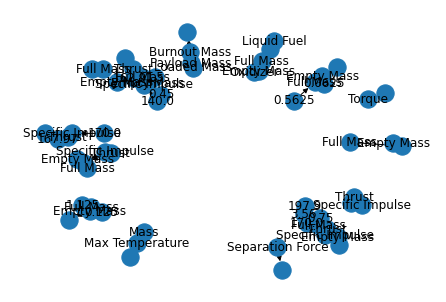

In [99]:
attribute_member_value_graph_labels = {}
for node in attribute_member_value_graph.nodes():
    if id_memo_dict[node]['@type'] == 'AttributeUsage':
        attribute_member_value_graph_labels.update({node: get_name_by_id(node)})
    elif id_memo_dict[node]['@type'] == 'LiteralReal':
        attribute_member_value_graph_labels.update({node: id_memo_dict[node]['value']})
    
NX.draw_spring(attribute_member_value_graph, labels=attribute_member_value_graph_labels)

### Match Attributes to Classifier types

Where the owningType of the Attribute usage is a classifier, use it as the base of the sequence.

In [100]:
classifier_instance_dicts[0].keys()

dict_keys(['RT-5 "Flea" Solid Fuel Booster', 'RT-10 "Hammer" Solid Fuel Booster', 'Solid Booster', 'Solid Stage', 'Liquid Stage', 'Rocket Stage', 'Coupler', 'LV-T45 "Swivel" Liquid Fuel Engine', 'Liquid Engine', 'FL-T100 Fuel Tank', 'FL-T200 Fuel Tank', 'Fuel Tank Section', 'Rocket', 'Kerbal Rocket Part'])

In [116]:
att_value_dicts = []
value_holders = []

for classifier_instance_dict in classifier_instance_dicts:

    att_value_dict = {}

    for att in att_uses:
        new_sequences = []
        att_owning_type = id_memo_dict[att['owningType']['@id']]
        if att_owning_type['@type'] == 'PartDefinition':
            if att_owning_type['name'] in classifier_instance_dict:
                for instance in classifier_instance_dict[att_owning_type['name']]:
                    new_sequence = []
                    new_sequence.append(instance)
                    
                    #new_sequence.append(att['name'])
                    
                    for value in get_att_literal_values(att):
                        #new_sequence.append(value['@id'])
                        new_holder = ValueHolder([instance], att['name'], value['value'])
                        value_holders.append(new_holder)
                        new_sequence.append(new_holder)
                        
                    if len(get_att_literal_values(att)) == 0:
                        new_holder = ValueHolder([instance], att['name'], None)
                        new_sequence.append(new_holder)
                    new_sequences.append(new_sequence)

        att_value_dict.update({att['@id']: new_sequences})
        
    att_value_dicts.append(att_value_dict)

In [117]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    
    att_value_dict = att_value_dicts[indx]
    
    for att in att_uses:
        new_sequences = []
        att_owning_type = id_memo_dict[att['owningType']['@id']]
        if att_owning_type['@type'] == 'PartUsage':
            #print('Found attribute ' + att_owning_type['name'])
            if att_owning_type['@id'] in feature_sequence_dictionary:
                for instance_sequence in feature_sequence_dictionary[att_owning_type['@id']]:
                    new_sequence = copy.deepcopy(instance_sequence)
                    
                    #new_sequence.append(att['name'])
                    
                    for value in get_att_literal_values(att):
                        #new_sequence.append(value['@id'])
                        new_holder = ValueHolder(instance_sequence, att['name'], value['value'])
                        value_holders.append(new_holder)
                        new_sequence.append(new_holder)
                        
                    if len(get_att_literal_values(att)) == 0:
                        new_holder = ValueHolder(instance_sequence, att['name'], None)
                        new_sequence.append(new_holder)
                    new_sequences.append(new_sequence)

            att_value_dict.update({att['@id']: new_sequences})
        
    att_value_dicts.append(att_value_dict)

In [118]:
for indx, att_value_dict in enumerate(att_value_dicts):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in att_value_dict:
            print(get_name_by_id(key) + ', id ' + key)
            for indx, seq in enumerate(att_value_dict[key]):
                if indx < 5:
                    seq_string = []
                    for member in seq:
                        if isinstance(member, str) and member in id_memo_dict:
                            obj = id_memo_dict[member]
                            # TODO: Create unique value objects for formula mapping
                            if obj['@type'] == 'LiteralReal':
                                seq_string.append(str(obj['value']) + ', id ' + member)
                        else:
                            seq_string.append(member)
                    print(seq_string)
                elif indx == 5:
                    print('..')

Solution #0
Specific Impulse, id 0a02f039-188c-45d7-a57b-6c050b4f0c72
[RT-5#1, RT-5#1.Specific Impulse (140.0)]
[RT-5#2, RT-5#2.Specific Impulse (140.0)]
[RT-5#3, RT-5#3.Specific Impulse (140.0)]
[RT-5#4, RT-5#4.Specific Impulse (140.0)]
[RT-5#5, RT-5#5.Specific Impulse (140.0)]
..
Full Mass, id 0e6482f7-aef6-4020-a3e1-a60201b4987d
[SS#1, SS#1.Full Mass (unset)]
[SS#2, SS#2.Full Mass (unset)]
[SS#3, SS#3.Full Mass (unset)]
Thrust, id 13d8aa14-64b6-4585-8e38-a84c86331155
[LV-T45#1, LV-T45#1.Thrust (unset)]
[LV-T45#2, LV-T45#2.Thrust (unset)]
[LV-T45#3, LV-T45#3.Thrust (unset)]
[LV-T45#4, LV-T45#4.Thrust (unset)]
[LV-T45#5, LV-T45#5.Thrust (unset)]
..
Empty Mass, id 1bf9bcc3-072e-4f30-abb4-11cfdde2be7f
[FL-T100#1, FL-T100#1.Empty Mass (0.0625)]
[FL-T100#2, FL-T100#2.Empty Mass (0.0625)]
[FL-T100#3, FL-T100#3.Empty Mass (0.0625)]
[FL-T100#4, FL-T100#4.Empty Mass (0.0625)]
[FL-T100#5, FL-T100#5.Empty Mass (0.0625)]
..
Full Mass, id 1c2f0f0e-8e7c-42b0-92f3-a26ce6b8a64f
[RT-10#1, RT-10#1.Ful

Now we need to do this for the feature sequences.

## Gather Expressions and Invocations and Build Expression Graph

In [103]:
expression_graph = NX.DiGraph()
expression_graph_labels = {}
expression_graph_ascii = ''

invocations = []


Memoize InvocationExpressions, BlockExpressions, FeatureReferenceExpressions, and ReferenceUsages

In [104]:
invocations = [invocation for invocation in non_relations if invocation['@type'] == 'InvocationExpression']
functions = [function for function in non_relations if function['@type'] == 'Function']
op_exprs = [function for function in non_relations if function['@type'] == 'OperatorExpression']
block_exprs = [block_expr for block_expr in non_relations if block_expr['@type'] == 'BlockExpression']
feature_refs = [feature_ref for feature_ref in non_relations if feature_ref['@type'] == 'FeatureReferenceExpression']
reference_uses = [ref_use for ref_use in non_relations if ref_use['@type'] == 'ReferenceUsage']

para_members = [para_member for para_member in relations if para_member['@type'] == 'ParameterMembership']
res_expr_members = [res_expr_member for res_expr_member in relations if res_expr_member['@type'] == 'ResultExpressionMembership']
ret_para_members = [ret_para_member for ret_para_member in relations if ret_para_member['@type'] == 'ReturnParameterMembership']

for invocation in invocations:
    id_memo_dict.update({invocation['@id']: invocation})
    
for function in functions:
    id_memo_dict.update({function['@id']: function})
    
for op_expr in op_exprs:
    id_memo_dict.update({op_expr['@id']: op_expr})
    
for block_expr in block_exprs:
    id_memo_dict.update({block_expr['@id']: block_expr})
    
for feature_ref in feature_refs:
    id_memo_dict.update({feature_ref['@id']: feature_ref})
    
for reference_use in reference_uses:
    id_memo_dict.update({reference_use['@id']: reference_use})

In [105]:
ofms = []
ofms.extend(para_members)
ofms.extend(res_expr_members)
ofms.extend(ret_para_members)

Get feature memberships from the expressions to their members.

In [106]:
for fm in feature_members:
    if fm['owningType']['@id'] in id_memo_dict:
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'InvocationExpression':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'Function':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
            expression_graph_labels.update({fm['owningType']['@id']: id_memo_dict[fm['owningType']['@id']]['name']})
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'OperatorExpression':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
            expression_graph_labels.update({fm['owningType']['@id']: id_memo_dict[fm['owningType']['@id']]['operator']})
            if fm['memberFeature']['@id'] in id_memo_dict:
                if id_memo_dict[fm['memberFeature']['@id']]['@type'] == 'FeatureReferenceExpression':
                    expression_graph_labels.update({fm['memberFeature']['@id']: 
                                                   id_memo_dict[id_memo_dict[fm['memberFeature']['@id']]['referent']['@id']]['name'] + ' (FeatRef)'})

for ofm in ofms:
    if ofm['owningType']['@id'] in id_memo_dict:
        if id_memo_dict[ofm['owningType']['@id']]['@type'] == 'BlockExpression':
            expression_graph.add_edge(ofm['owningType']['@id'], ofm['memberFeature']['@id'])
            if ofm['memberFeature']['@id'] in id_memo_dict:
                if id_memo_dict[ofm['memberFeature']['@id']]['@type'] == 'FeatureReferenceExpression':
                    expression_graph_labels.update({ofm['memberFeature']['@id']: 
                                                   id_memo_dict[id_memo_dict[ofm['memberFeature']['@id']]['referent']['@id']]['name'] + ' (FeatRef)'})
            if get_name_by_id(ofm['memberFeature']['@id']) is not None:
                if get_metatype_by_id(ofm['memberFeature']['@id']) == 'ReferenceUsage':
                    ref_type_name = id_memo_dict[id_memo_dict[ofm['memberFeature']['@id']]['type'][0]['@id']]['name']
                    expression_graph_labels.update({ofm['memberFeature']['@id']: 
                                                    get_name_by_id(ofm['memberFeature']['@id']) + ':' + ref_type_name})
                else:
                    expression_graph_labels.update({ofm['memberFeature']['@id']: get_name_by_id(ofm['memberFeature']['@id'])})
                    
for ft in feature_types:
    if ft['typedFeature']['@id'] in id_memo_dict:
        if id_memo_dict[ft['type']['@id']]['@type'] == 'Function':
            expression_graph.add_edge(ft['typedFeature']['@id'], ft['type']['@id'])
            expression_graph_labels.update({ft['type']['@id']: id_memo_dict[ft['type']['@id']]['name']})

Gather the body and parameters of the invocation.

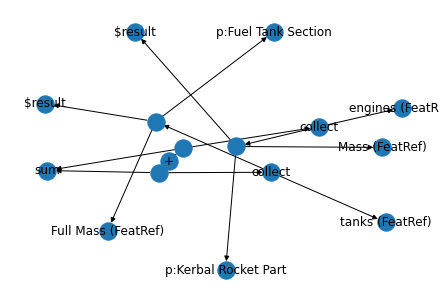

In [107]:
NX.draw_spring(expression_graph, labels=expression_graph_labels)

The final step is to connect this graph to the created ValueHolders and generated sets of calculations to be executed.

## Perform Staging Mass Analysis

- [ ] TODO: Strengthen this with analyses that actually do the calculation
- [ ] TODO: Accommodate associations between tanks and engines to make delta-V and Isp calculations work properly

This is very specific to a given calculation - need to have a kernel for expanding the calculations just as with inspecting type hierarchy and multiplicity

In [108]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    no_stages = len(feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'])
    print(str(no_stages))
    for stag in range(1, no_stages + 1):
        stage_empty_mass = 0
        stage_full_mass = 0
        stage_specific_impulse = 0
        # add up the starter mass for the stage and the burnout mass
        stage_instance = feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'][stag - 1][-1]
        print(str(stage_instance) + ": " + str(classifier_memo_dicts[indx][stage_instance.name]))
        if '54c2e565-ede4-4c12-a44c-2277566a2861' in feature_sequence_dictionary:
            booster_instances = \
                [booster[-1] for booster in feature_sequence_dictionary['54c2e565-ede4-4c12-a44c-2277566a2861']
                     if str(booster[0]) == str(stage_instance)]
            print('Booster instance length = ' + str(len(booster_instances)))
            for booster in booster_instances:
                for clz in classifier_memo_dicts[indx][booster.name]:
                    if clz in partitioned_multiplicity_dicts[indx]:
                        pass
                    else:
                        empty_mass = type_values['Empty Mass'][clz]
                        full_mass = type_values['Full Mass'][clz]
                        specific_impulse = type_values['Specific Impulse'][clz]

                        stage_empty_mass = stage_empty_mass + empty_mass
                        stage_full_mass = stage_full_mass + full_mass
                        stage_specific_impulse = stage_specific_impulse + specific_impulse
            if len(booster_instances) > 0:
                stage_specific_impulse = stage_specific_impulse / len(booster_instances)
        
        if stage_empty_mass > 0.0:
            booster_delta_V = 9.81 * stage_specific_impulse * math.log(stage_full_mass / stage_empty_mass)
        
        if indx < 3:
            print ('Stage booster full mass is ' + str(stage_full_mass))
            print ('Stage booster empty mass is ' + str(stage_empty_mass))
            print ('Stage booster specific impulse is ' + str(stage_specific_impulse))
            print ('Stage booster delta-V is ' + str(booster_delta_V))

KeyError: '31a4436f-07fd-48c6-b503-9d186d925c3c'